# Example notebook for collecting data, training and evaluating the model

## Importing

In [41]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import BaggingRegressor

from sklearn.metrics import root_mean_squared_error as rmse

import salishsea_tools.viz_tools as sa_vi

## Files Reading

In [42]:
# The location of the file
ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')

# Downgrading the resolution
ds = ds.isel(time_counter = (np.arange(0, len(ds.time_counter),2)), 
    y=(np.arange(ds.y[0], ds.y[-1], 5)), 
    x=(np.arange(ds.x[0], ds.x[-1], 5)))

# Selecting the first 2 years
dataset = ds.sel(time_counter = slice('2007-2-15', '2009-2-15'))


## Opening the dataset and its features

<xarray.Dataset> Size: 48MB
Dimensions:                 (time_counter: 76, y: 180, x: 80)
Coordinates:
  * time_counter            (time_counter) datetime64[ns] 608B 2007-02-15T12:...
  * y                       (y) int64 1kB 0 5 10 15 20 ... 875 880 885 890 895
  * x                       (x) int64 640B 0 5 10 15 20 ... 375 380 385 390 395
Data variables:
    Temperature_(0m-15m)    (time_counter, y, x) float32 4MB ...
    Temperature_(15m-100m)  (time_counter, y, x) float32 4MB ...
    Salinity_(0m-15m)       (time_counter, y, x) float32 4MB ...
    Salinity_(15m-100m)     (time_counter, y, x) float32 4MB ...
    Silicon                 (time_counter, y, x) float32 4MB ...
    Nitrate                 (time_counter, y, x) float32 4MB ...
    Ammonium                (time_counter, y, x) float32 4MB ...
    Diatom                  (time_counter, y, x) float32 4MB ...
    Flagellate              (time_counter, y, x) float32 4MB ...
    Microzooplankton        (time_counter, y, x) float32

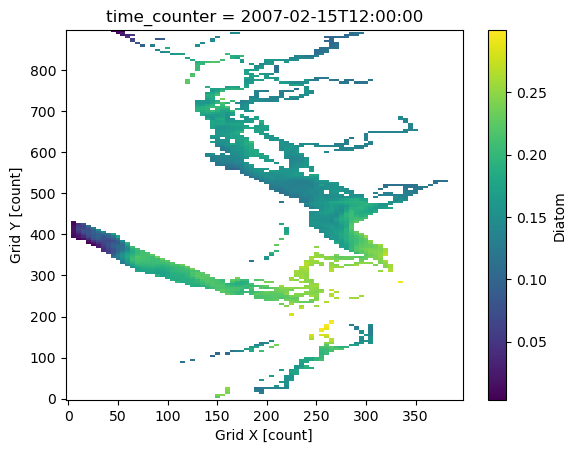

In [43]:
# Printing the features of the dataset
print(dataset)

# Plotting diatoms for the first day
dataset.Diatom[0].plot()

## Datasets Preparation

In [44]:
# Here I am packing all of them in one variable, named drivers

drivers = np.stack([np.ravel(dataset['Temperature_(0m-15m)']),
    np.ravel(dataset['Temperature_(15m-100m)']), 
    np.ravel(dataset['Salinity_(0m-15m)']),
    np.ravel(dataset['Salinity_(15m-100m)']),
   
    # These 4 are tricky to flatten, but this is the right way
    np.tile(np.repeat(dataset.y, len(dataset.x)), len(dataset.time_counter)),
    np.tile(dataset.x, len(dataset.time_counter)*len(dataset.y)),
    np.repeat(dataset.time_counter.dt.month, len(dataset.x)*len(dataset.y)),
    np.repeat(dataset.time_counter.dt.day, len(dataset.x)*len(dataset.y))
    ])

# Removing of nans
indx = np.where(~np.isnan(drivers).any(axis=0))
drivers = drivers[:,indx[0]]

diat = np.ravel(dataset['Diatom'])
diat = diat[indx]

# Transpose to bring it to the format (samples, features)
drivers = drivers.transpose()

# 1st sample - grid box
drivers[0]

array([  8.52399445,   8.59896278,  28.21989632,  28.40815926,
         5.        , 150.        ,   2.        ,  15.        ])

## Training 

In [45]:
# First I define the model, with its transformers and regressor
model = TransformedTargetRegressor(regressor=make_pipeline(ColumnTransformer(
    transformers=[("temporal", OneHotEncoder(), [6,7]), ("spatial", OneHotEncoder(), [4,5])],remainder=StandardScaler()),
    MLPRegressor(alpha=0.001, learning_rate='adaptive', epsilon=1e-07, max_iter=500)), 
    transformer=QuantileTransformer())

# Loading the model in a bagging regressor and training it
regr = BaggingRegressor(model, n_estimators=10, n_jobs=-1).fit(drivers,diat)
regr

BaggingRegressor(estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                                                 ColumnTransformer(remainder=StandardScaler(),
                                                                                                   transformers=[('temporal',
                                                                                                                  OneHotEncoder(),
                                                                                                                  [6,
                                                                                                                   7]),
                                                                                                                 ('spatial',
                                                                                                                  OneHotEncoder(),
                                                                                                                  [4,
                                                                                                                   5])])),
                                                                                ('mlpregressor',
                                                                                 MLPRegressor(alpha=0.001,
                                                                                              epsilon=1e-07,
                                                                                              learning_rate='adaptive',
                                                                                              max_iter=500))]),
                                                      transformer=QuantileTransformer()),
                 n_jobs=-1)

## Testing

In [56]:
# Selecting one day in the future - the result will not look good, we do it just as an example
dataset = ds.sel(time_counter = slice('2023-4-20', '2023-4-20'))

# Same as before
drivers = np.stack([np.ravel(dataset['Temperature_(0m-15m)']),
    np.ravel(dataset['Temperature_(15m-100m)']), 
    np.ravel(dataset['Salinity_(0m-15m)']),
    np.ravel(dataset['Salinity_(15m-100m)']),
    np.tile(np.repeat(dataset.y, len(dataset.x)), len(dataset.time_counter)),
    np.tile(dataset.x, len(dataset.time_counter)*len(dataset.y)),
    np.repeat(dataset.time_counter.dt.month, len(dataset.x)*len(dataset.y)),
    np.repeat(dataset.time_counter.dt.day, len(dataset.x)*len(dataset.y))
    ])

# Removing of nans
indx = np.where(~np.isnan(drivers).any(axis=0))
drivers = drivers[:,indx[0]]

diat = np.ravel(dataset['Diatom'])
diat = diat[indx]

# Transpose to bring it to the format (samples, features)
drivers = drivers.transpose()

drivers[0]

array([  8.46106243,   8.30505657,  28.68799591,  28.62046242,
         5.        , 150.        ,   4.        ,  20.        ])

## Prediction and evaluation

In [47]:
predicted = regr.predict(drivers)

print('The correlation coefficient is:', np.corrcoef(diat,predicted)[0,1])
print('The rmse is:', rmse(diat,predicted))

# Creating the map for the predicted values
indx2 = np.full((len(dataset.y)*len(dataset.x)),np.nan)
indx2[indx] = predicted
model = np.reshape(indx2,(len(dataset.y),len(dataset.x)))

# Preparation of the dataarray 
model = xr.DataArray(model,
    coords = {'y': dataset.y, 'x': dataset.x},
    dims = ['y','x'],
    attrs=dict(units="mmol m-2"))

The correlation coefficient is: 0.2748705038523614
The rmse is: 0.19409196395011957


## Scatter plot

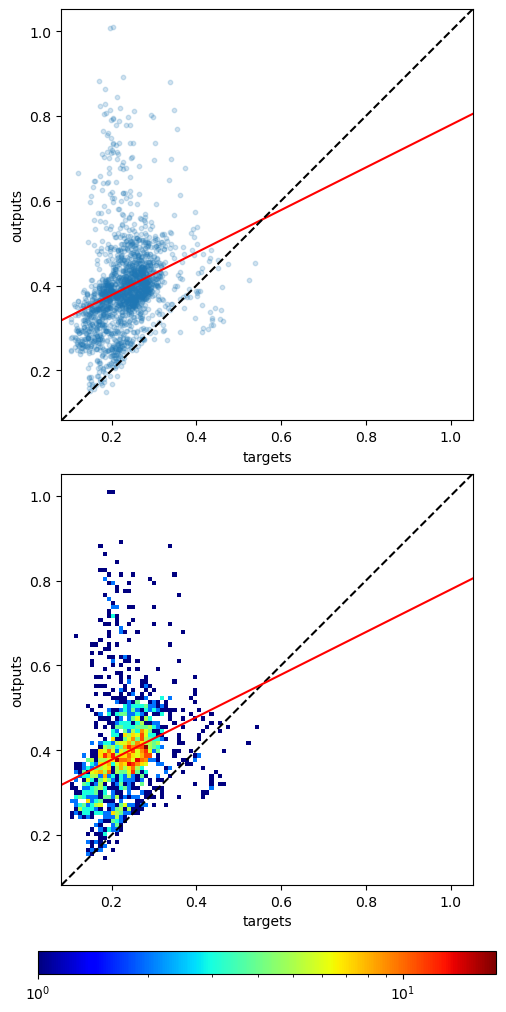

In [48]:
# compute slope m and intercept b
m, b = np.polyfit(diat, predicted, deg=1)

fig, ax = plt.subplots(2, figsize=(5,10), layout='constrained')

ax[0].scatter(diat, predicted, alpha = 0.2, s = 10)

lims = [np.min([ax[0].get_xlim(), ax[0].get_ylim()]),
    np.max([ax[0].get_xlim(), ax[0].get_ylim()])]

# plot fitted y = m*x + b
ax[0].axline(xy1=(0, b), slope=m, color='r')

ax[0].set_xlabel('targets')
ax[0].set_ylabel('outputs')
ax[0].set_xlim(lims)
ax[0].set_ylim(lims)
ax[0].set_aspect('equal')

ax[0].plot(lims, lims,linestyle = '--',color = 'k')

h = ax[1].hist2d(diat, predicted, bins=100, cmap='jet', 
    range=[lims,lims], cmin=0.1, norm='log')

ax[1].plot(lims, lims,linestyle = '--',color = 'k')

# plot fitted y = m*x + b
ax[1].axline(xy1=(0, b), slope=m, color='r')

ax[1].set_xlabel('targets')
ax[1].set_ylabel('outputs')
ax[1].set_aspect('equal')

fig.colorbar(h[3],ax=ax[1], location='bottom')

plt.show()

## Plotting

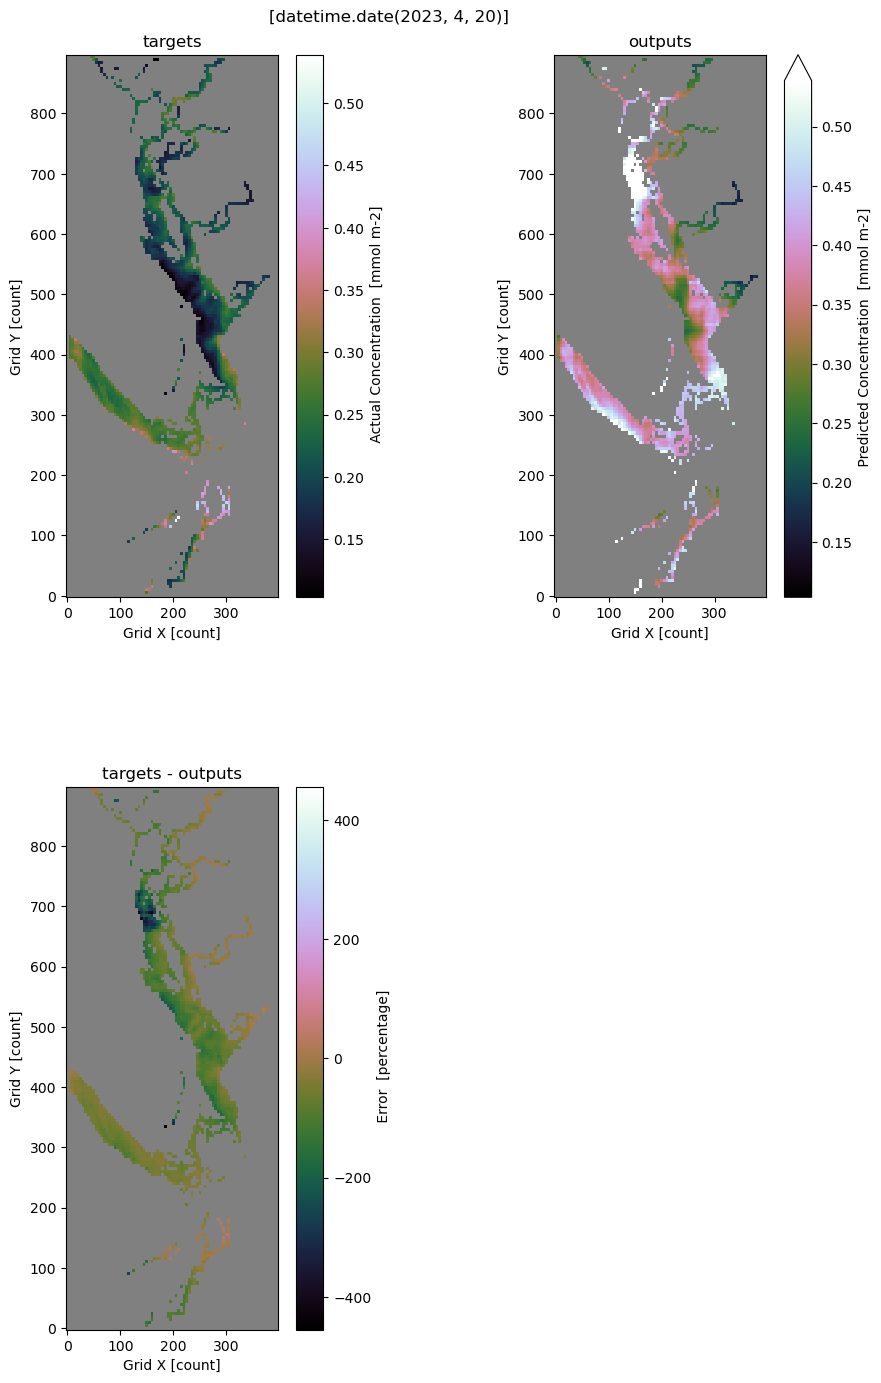

In [55]:
fig, ax = plt.subplots(2,2, figsize = (10,15))

cmap = plt.get_cmap('cubehelix')
cmap.set_bad('gray')

dataset.Diatom.plot(ax=ax[0,0], cmap=cmap, vmin = diat.min(), vmax =diat.max(), cbar_kwargs={'label':' Actual Concentration  [mmol m-2]'})
model.plot(ax=ax[0,1], cmap=cmap, vmin = diat.min(), vmax = diat.max(), cbar_kwargs={'label':' Predicted Concentration  [mmol m-2]'})
((dataset.Diatom-model) / dataset.Diatom * 100).plot(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': ' Error  [percentage]'})

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.95, 
    top=0.95, 
    wspace=0.35, 
    hspace=0.35)

sa_vi.set_aspect(ax[0,0])
sa_vi.set_aspect(ax[0,1])
sa_vi.set_aspect(ax[1,0])

ax[0,0].title.set_text('targets')
ax[0,1].title.set_text('outputs')
ax[1,0].title.set_text('targets - outputs')
ax[1,1].axis('off')

fig.suptitle(dataset.time_counter.dt.date.values)

plt.show()
